In [60]:
import datetime
import pandas as pd
import numpy as np
import scipy
import sklearn
from collections import OrderedDict
from sklearn.decomposition import PCA
from altair import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from IPython.display import display

In [61]:
cldir = './data/CL/'
rutdir = './data/RUT/'
gldir = './data/GLD/'
src = cldir

data = pd.read_csv(src + '/1_merged/in_sampleFF.csv')

labelName = 'Z_dailydir'
label_list = ['Z_dailydir2', 'Z_dailydir']
pricestats=['Date', 'Z_dailypct']
news_list = tuple(sorted([col for col in data.columns if (col[0]=='N' and 'buzz' not in col)]))
social_list = tuple(sorted([col for col in data.columns if (col[0]=='S' and 'buzz' not in col)]))
sent_list = news_list + social_list
full_list = sent_list + ('Z_dailypct',)
data.dropna(axis=0, inplace=True)
data.head(5)

,Date,N_buzz,N_conflict,N_consumptionVolume,N_emotionVsFact,N_fear,N_gloom,N_joy,N_longShort,N_longShortForecast,...,X_Prev. Day Open Interest,X_Settle,X_Volume,X_dailydir,X_dailypct,Y_day,Z_dailydir,Z_dailypct,Y_year,Z_dailydir2
25,2000-01-26,1705.5,-0.019936,-0.000579,0.129566,0.022574,0.035473,0.002932,0.008502,0.000586,...,135469.0,103.589979,67173.0,-1.0,-0.015559,2,-1.0,-0.018678,2000,-2.0
26,2000-01-27,1467.5,-0.005792,-0.000341,0.141823,0.009881,0.039523,0.002726,-0.020102,0.000586,...,135134.0,101.655109,89124.0,-1.0,-0.018678,3,-1.0,-0.003660,2000,-1.0
27,2000-01-28,1788.1,-0.025726,-0.000559,0.134626,0.014261,0.014820,0.000559,-0.013702,0.000586,...,130615.0,101.283018,67368.0,-1.0,-0.003660,4,1.0,0.015430,2000,2.0
30,2000-01-31,1331.2,-0.004883,0.001127,0.126540,0.006761,0.022912,0.002254,-0.000751,0.000586,...,133257.0,102.845798,81841.0,1.0,0.015430,0,1.0,0.020984,2000,2.0
31,2000-02-01,1769.6,-0.027125,-0.001413,0.127204,0.006499,0.015258,0.002825,-0.005651,0.000586,...,131731.0,105.003923,76405.0,1.0,0.020984,1,-1.0,-0.023742,2000,-2.0


In [62]:
def plot_feature(feature=None, label=None,
                remove_zeros=True,                                           #pre-processing options
                atomic_transform=lambda x:x, delta_transform=lambda x:x, combo='delta_atomic', #processing options
                low_clip=-1.0, high_clip=1.0,
                show_class='all',
                data=data):                                                             #post-processing options

    assert(feature and label)
    output = pd.DataFrame({feature: data[feature], label: data[label], 'year': data['Y_year']})
    output.dropna(axis=0, subset=[label], inplace=True) #Drop rows with no label
    output.dropna(axis=0, subset=[feature], inplace=True)
    output[label] = output[label].astype(int)
    
    if (remove_zeros):
        output = output[output[feature] != 0]

    #TODO - upper and lower bound filtering (throw out middle)
        #past_period - number of rows behind the "big moves" to keep in
        #Need this for delta transforms

    if (combo == 'atomic'):
        output[combo] = atomic_transform(output[feature])
    elif (combo == 'delta'):
        output[combo] = delta_transform(output[feature])
    elif (combo == 'atomic_delta'):
        output[combo] = atomic_transform(delta_transform(output[feature]))
    elif (combo == 'delta_atomic'):
        output[combo] = delta_transform(atomic_transform(output[feature]))
    else:
        output[combo] = output[feature]

    low_clip = low_clip if low_clip > output[combo].min() else output[combo].min()
    high_clip = high_clip if high_clip < output[combo].max() else output[combo].max()
    output[combo] = np.clip(output[combo], low_clip, high_clip)

    #Post processing
    if (show_class != 'all'):
        if (show_class == 'up'):
            output = output[output[label] > 1]
        elif (show_class == 'down'):
            output = output[output[label] < -1]
        elif (show_class == 'sideways'):
            output = output[output[label] == 0]
    
    #TODO - add year specific removal option

    data_space = np.linspace(0, len(output[combo])-1, num=len(output[combo]))
    plt.figure(figsize=(25,10))
    #plt.figure().tight_layout()
    plt.title('Data Segmentation Graph')
    plt.xlabel('Observation')
    plt.ylabel('Feature Value')
    plt.xlim([data_space.min()-100, data_space.max() + 100])
    plt.grid(b=True, which='major', axis='y')
    #textstr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$'%(mean, median, sdev)

    norm = mpl.colors.Normalize(vmin=output[label].min(), vmax=output[label].max()) 
    plt.scatter(data_space, output[combo], c=norm(output[label]), cmap=plt.cm.jet_r)
    plt.colorbar()
    plt.show()

    sent_means = []
    sent_vars = []
    combo_means = []
    combo_vars = []
    class_values = sorted(output[label].unique())
    for class_value in class_values:
        sent_means.append(output.loc[output[label] == class_value, feature].mean())
        combo_means.append(output.loc[output[label] == class_value, combo].mean())
        sent_vars.append(output.loc[output[label] == class_value, feature].var())
        combo_vars.append(output.loc[output[label] == class_value, combo].var())
    fig = plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('stats segmented by class label')
    ax[0].set_title('mean')
    ax[0].set_ylabel('feature value')
    ax[0].plot(class_values, sent_means, 'ok', label='sent_means')
    ax[0].plot(class_values, combo_means, 'r^', label='combo_means')
    ax[0].legend()
    
    ax[1].set_title('variance')
    ax[1].set_xlabel('label value')
    ax[1].plot(class_values, sent_vars, 'ok', label='sent_vars')
    ax[1].plot(class_values, combo_vars, 'r^', label='combo_vars')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    return

#config options
atomic_fn_options = OrderedDict({'nothing': lambda x:x, 'round': lambda a: np.around(a, 2), 'log10':np.log10, 'sine':np.sin, 'sinh':np.sinh})
delta_fn_options = OrderedDict({'nothing': lambda x:x, 'log10':np.log10, 'sine':np.sin, 'sinh':np.sinh})

In [63]:
num_pca=3
pca_comp_names = tuple(['comp_'+str(i) for i in range(num_pca)])
pca = PCA(n_components = num_pca)
#pca = PCA(n_components='mle', svd_solver='full')
proj = pca.fit_transform(data[list(news_list)])

pca_comps = pd.DataFrame(data=proj[:, :], columns=pca_comp_names)
for labl in label_list:
    pca_comps[labl] = data[labl]
pca_comps['Y_year'] = data['Y_year']

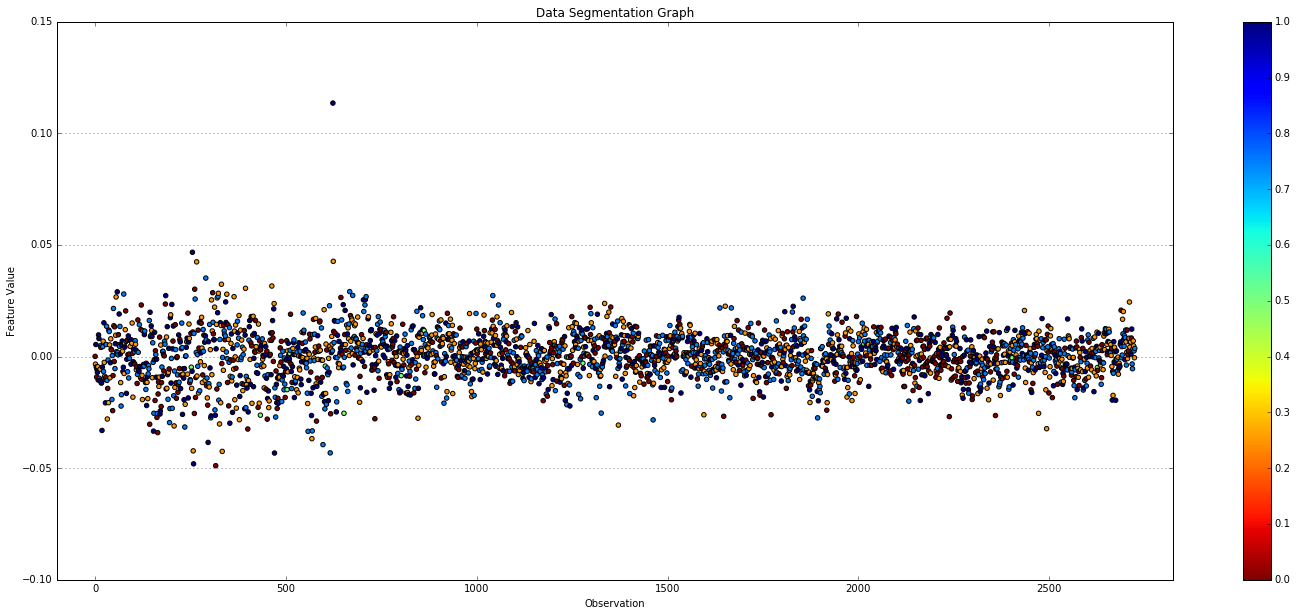

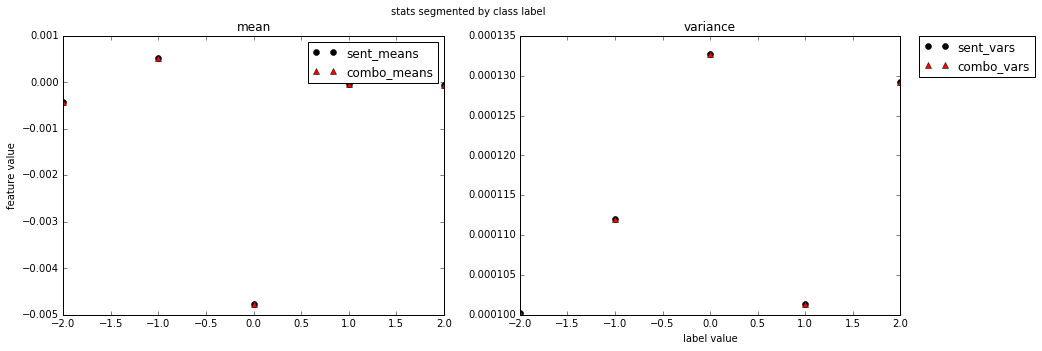

In [64]:
interact(plot_feature,
                feature=pca_comp_names,
                label=tuple(label_list),
                remove_zeros=OrderedDict({'remove': True, 'keep': False}),
                atomic_transform=atomic_fn_options,
                delta_transform=delta_fn_options,
                combo=('none','atomic','delta','atomic_delta','delta_atomic'),
                low_clip=(-1.0, 0.0, .001),
                high_clip=(.0, 1.0, .001),
                show_class=('all', 'up', 'down', 'sideways'),
                data=fixed(pca_comps));